In [169]:
import copy
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec
from matplotlib.lines import Line2D
from mxlpy import Model, Simulator, make_protocol
from mxlpy.parallel import parallelise
from matplotlib.patches import ConnectionPatch

sys.path.append(os.path.abspath('..'))

from model import Li2021

here = Path("").absolute()

def save_fig(fig_num: str) -> Path:
    here = Path("").absolute()
    name = "Li2021"
    plt.savefig(here / f"{name.lower()}_fig{fig_num}.svg", format="svg", bbox_inches="tight")

## Str Dictionary

In [170]:
pfd_str = "PPFD"
npq_str = "NPQ"
ql_str = "qL"
qlact_str = "qL_act"
phipsii_str = "Phi2"
dphV_str = "delta_pH_inVolts"
deltapsi_str = "Dy"
pmf_str = "pmf"
Kplus_str = "K_lumen"
Clminus_str = "Cl_lumen"

# Figure 3

In [171]:
def create_fig3_sim(
    model: Model,
    pfd_str: str,
):
    light_100 = make_protocol([(20 * 60, {pfd_str: 100}), (5 * 60, {pfd_str: 0})])
    light_500 = make_protocol([(20 * 60, {pfd_str: 500}), (5 * 60, {pfd_str: 0})])
    
    param_dict = {
        "wt": {},
        "c": {"k_CLCE": 0},
        "v": {"k_VCCN1": 0},
        "k": {"k_KEA": 0},
        "cv": {"k_CLCE": 0, "k_VCCN1": 0},
        "ck": {"k_CLCE": 0, "k_KEA": 0},
        "vk": {"k_VCCN1": 0, "k_KEA": 0},
        "vck": {"k_CLCE": 0, "k_VCCN1": 0, "k_KEA": 0},
    }
    
    final_res_sim = {}
    final_res_stst = {}
    
    for gt, params in param_dict.items():
        new_model = copy.deepcopy(model)
        new_model.update_parameters(params)
        
        res_sim = {}
        res_stst = {}
        for pfd, protocol in zip([500, 100], [light_500, light_100]):
            s = Simulator(new_model)
            s.simulate_protocol(protocol, time_points_per_step=100)
            res_sim[pfd] = s.get_result().unwrap_or_err().get_combined()
            
            # s = Simulator(model)
            # s.simulate_to_steady_state()
            # res_stst[pfd] = s.get_result().unwrap_or_err().get_combined()
        
        final_res_sim[gt] = pd.concat(res_sim, names=["PPFD"], axis=0)
        # final_res_stst[gt] = pd.concat(res_stst, names=["PPFD"], axis=0)
        
    final_res_sim = pd.concat(final_res_sim, names=["Genotype"], axis=0)
    # final_res_stst = pd.concat(final_res_stst, names=["Genotype"], axis=0)
    
    return final_res_sim, final_res_stst

def create_fig3_plot(
    res_sim: pd.DataFrame,
    res_stst: pd.DataFrame,
    npq_str: str,
    ql_str: str,
    phipsii_str: str,
    dphV_str: str,
):
    fig = plt.figure(figsize=(20, 5))
    outer_grid = gridspec.GridSpec(2, 1, hspace=1)
    inner_top = gridspec.GridSpecFromSubplotSpec(1, 5, subplot_spec=outer_grid[0], wspace=0.2)
    inner_bottom = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=outer_grid[1], wspace=0.5)

    axs = {}
    for i, name in enumerate(["qL", "PhiPSII", "NPQ", "pH", "DES"]):
        ax = fig.add_subplot(inner_top[0, i])
        for edge in ["top", "right"]:
            ax.spines[edge].set_visible(False)
        axs[name] = ax
        
    for i, name in enumerate(["c", "v", "k", "cv", "ck", "vk", "vck"]):
        ax = fig.add_subplot(inner_bottom[0, i])
        for edge in ["top", "right"]:
            ax.spines[edge].set_visible(False)
        axs[name] = ax
    
    style_dict = {
        "100": {"color": "black"},
        "500": {"color": "red"},
    }
    
    pH_xlabels = ["WT", "c", "v", "k", "cv", "ck", "vk", "vck"]
    for ax in [axs["pH"], axs["DES"]]:
        ax.set_xticks(range(len(pH_xlabels)))
        ax.set_xticklabels(pH_xlabels, rotation=45)
        ax.set_xlim(-0.5, len(pH_xlabels)-0.5)
        
    axs["pH"].set_title(r"$\Delta \Delta$pH")
    axs["DES"].set_title("DES")
    
    for gt in res_sim.index.get_level_values("Genotype").unique():
        gt_df_sim = res_sim.loc[gt]
        # gt_df_stst = res_stst.loc[gt]
        
        for pfd in gt_df_sim.index.get_level_values("PPFD").unique():
            if gt == "wt":
                axs["qL"].plot(gt_df_sim.loc[pfd, ql_str], **style_dict[str(pfd)])
                axs["PhiPSII"].plot(gt_df_sim.loc[pfd, phipsii_str], **style_dict[str(pfd)])
                axs["NPQ"].plot(gt_df_sim.loc[pfd, npq_str], **style_dict[str(pfd)])
            else:
                delta_npq = gt_df_sim.loc[pfd, npq_str] - res_sim.loc["wt"].loc[pfd, npq_str]
                axs[gt].plot(delta_npq, **style_dict[str(pfd)])
                
                # axs["pH"].scatter(gt_df_sim.loc[pfd, dphV_str], delta_npq, **style_dict[str(pfd)], label=f"{gt} {pfd}")
                # delta_deltapH = gt_df_stst.loc[pfd, dphV_str] - res_stst.loc["wt"].loc[pfd, dphV_str]
                # axs["pH"].plot(delta_deltapH, **style_dict[str(pfd)])
    
    for ax_str in ["qL", "PhiPSII", "NPQ", "c", "v", "k", "cv", "ck", "vk", "vck"]:
        axs[ax_str].set_xlabel("Time (min)")
        axs[ax_str].set_xlim(0*60, 25*60)
        axs[ax_str].set_xticks(np.linspace(0, 25, 6) * 60, labels=np.linspace(0, 25, 6, dtype=int))
    
    axs["qL"].set_ylim(0, 1.2)
    axs["qL"].set_title("qL")
    
    axs["PhiPSII"].set_ylim(0, 1.0)
    axs["PhiPSII"].set_title(r"$\Phi$II")
    
    axs["NPQ"].set_ylim(0, 2.5)
    axs["NPQ"].set_title("NPQ")
    
    for ax_str in ["c", "v", "k", "cv", "ck", "vk", "vck"]:
        axs[ax_str].set_ylim(-0.7, 0.7)
        axs[ax_str].set_yticks(np.linspace(-0.6, 0.6, 5))
        axs[ax_str].set_ylabel(r"$\Delta$NPQ")
        axs[ax_str].set_title(ax_str)
        
    custom_lines = [
        Line2D([0], [0], color="black", lw=2, label=r"Simulated 100 $\mu$mol m$^{-2}$ s$^{-1}$"),
        Line2D([0], [0], color="red", lw=2, label=r"Simulated 500 $\mu$mol m$^{-2}$ s$^{-1}$")
    ]
    
    fig.legend(
        handles=custom_lines,
        ncol=2,
        frameon=False,
        loc="center left",
        bbox_to_anchor=(0.2, 0.47) 
    )

    return fig, axs


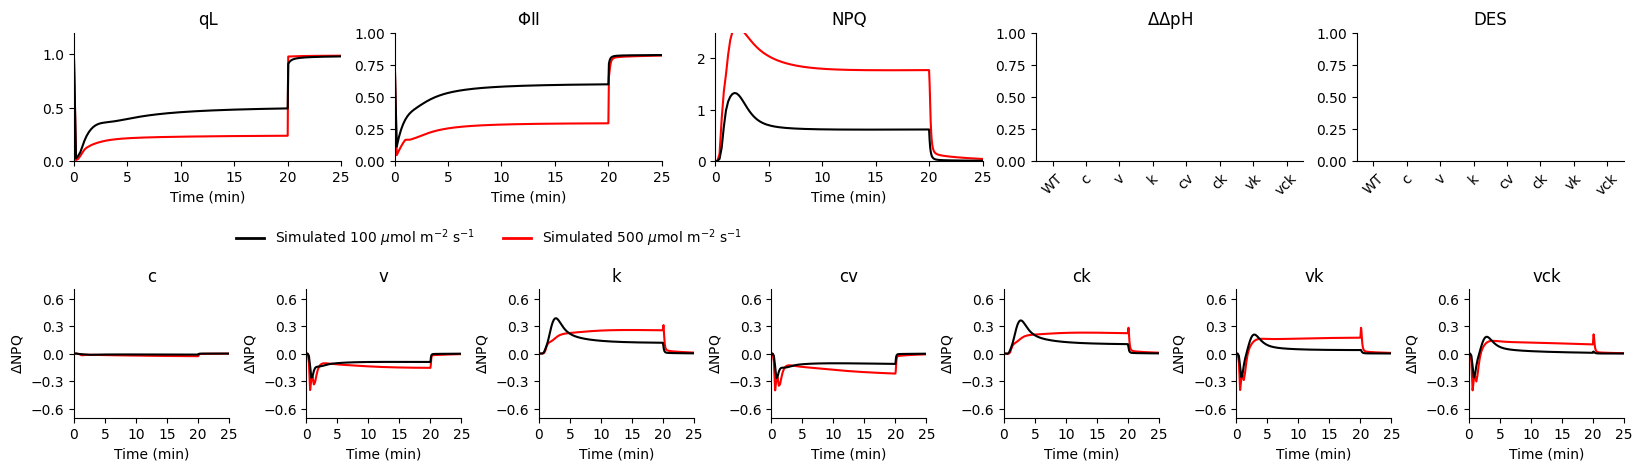

In [172]:
fig3_res_sim, fig3_res_stst = create_fig3_sim(
    model=Li2021(),
    pfd_str=pfd_str
)

create_fig3_plot(
    res_sim=fig3_res_sim,
    res_stst=fig3_res_stst,
    npq_str=npq_str,
    ql_str=ql_str,
    phipsii_str=phipsii_str,
    dphV_str=dphV_str
)

save_fig("3")

# Figure 4

In [173]:
def create_fig4_sim(
    model: Model,
    pfd_str: str,
    Kplus_str: str,
    Clminus_str: str,
):
    
    darktime = 1
    
    light_100 = make_protocol([(5 * 60, {pfd_str: 100})])
    light_500 = make_protocol([(5 * 60, {pfd_str: 500})])
    
    param_dict = {
        "wt": {},
        "v": {"k_VCCN1": 0},
        "k": {"k_KEA": 0},
        "vck": {"k_CLCE": 0, "k_VCCN1": 0, "k_KEA": 0},
    }
    
    final_res_sim = {}

    
    for gt, params in param_dict.items():
        new_model = copy.deepcopy(model)
        new_model.update_parameters(params)
        
        res_sim = {}
        res_stst = {}
        for pfd, protocol in zip([500, 100], [light_500, light_100]):
            s = Simulator(new_model)
            s.simulate_protocol(protocol, time_points_per_step=100)
            sim_res = s.get_result().unwrap_or_err().get_combined()
            rhs_res = s.get_result().unwrap_or_err().get_right_hand_side()
            rhs_res = rhs_res[[Kplus_str, Clminus_str]]
            rhs_res = rhs_res.rename(columns={Kplus_str: "K_flux", Clminus_str: "Cl_flux"})
            res_sim[pfd] = pd.concat([sim_res, rhs_res], axis=1)
        
        final_res_sim[gt] = pd.concat(res_sim, names=["PPFD"], axis=0)
        
    final_res_sim = pd.concat(final_res_sim, names=["Genotype"], axis=0)

    return final_res_sim

def create_fig4_plot(
    res: pd.DataFrame,
    deltapsi_str: str,
    dphV_str: str,
    pmf_str: str,
    Kplus_str: str,
    Clminus_str: str,
):
    
    fig = plt.figure(figsize=(15, 9))
    outer_grid = gridspec.GridSpec(1, 2, wspace=0.3, width_ratios=[2, 1], figure=fig)
    left_side = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=outer_grid[0], wspace=1.5, hspace=0.3)
    right_side = gridspec.GridSpecFromSubplotSpec(5, 1, subplot_spec=outer_grid[1], hspace=0, height_ratios=[0.3, 1, 1, 1, 1])
    
    axs = {}
    for i, pfd in enumerate(["100", "500"]):
        for j, gt in enumerate(["wt", "v", "k"]):
            ax = fig.add_subplot(left_side[j, i])
            ax.spines["top"].set_visible(False)
            axs[f"{gt}_{pfd}"] = ax
        
        for j, side in enumerate(["top", "bottom"]):
            ax = fig.add_subplot(right_side[i*2 + j + 1, 0])
            for edge in ["top", "right", "left", "bottom"]:
                ax.spines[edge].set_visible(False)
            axs[f"vck_{pfd}_{side}"] = ax
        
    style_dict = {
        "deltapsi": {"color": "black"},
        "dpHV": {"color": "#0ef615"},
        "pmf": {"color": "#da56d7"},
        "K+": {"color": "#4f46d6"},
        "Cl-": {"color": "#ff0000"},
    }
    
    for pfd in [100, 500]:
        axs[f"wt_{pfd}"].set_title(f"{pfd} µmol m⁻² s⁻¹\nWT")
        axs[f"v_{pfd}"].set_title("VCCN1")
        axs[f"k_{pfd}"].set_title("KEA3")
        
        for gt in ["wt", "v", "k"]:
            axs[f"{gt}_{pfd}"].set_xlim(0*60, 5*60)
            axs[f"{gt}_{pfd}"].set_xticks(np.linspace(0, 5, 6) * 60, labels=np.linspace(0, 5, 6, dtype=int))
    
    for gt in res.index.get_level_values("Genotype").unique():
        
        for pfd in res.loc[gt].index.get_level_values("PPFD").unique():
            
            if gt == "wt":
                axs[f"{gt}_{pfd}"].plot(res.loc[gt, pfd][deltapsi_str], **style_dict["deltapsi"])
                dphV_twinx = axs[f"{gt}_{pfd}"].twinx()
                dphV_twinx.plot(res.loc[gt, pfd][dphV_str], **style_dict["dpHV"])
                dpmf_twinx = axs[f"{gt}_{pfd}"].twinx()
                dpmf_twinx.plot(res.loc[gt, pfd][pmf_str], **style_dict["pmf"])
                
                axs[f"{gt}_{pfd}"].set_ylabel(r"$\Delta\Psi$(V)", color=style_dict["deltapsi"]["color"], rotation=0, ha="right")
                
                axs[f"{gt}_{pfd}"].set_ylim(-0.005, 0.075)
                axs[f"{gt}_{pfd}"].set_yticks(np.linspace(0, 0.06, 4))
                
                dphV_twinx.set_ylabel(r"$\Delta$pH/V", color=style_dict["dpHV"]["color"], rotation=0, ha="right", va="center")
                
                dphV_twinx.set_ylim(0, 0.12)
                dphV_twinx.set_yticks(np.linspace(0, 0.12, 7))
                
                dpmf_twinx.spines.right.set_color(style_dict["pmf"]["color"])
                dpmf_twinx.tick_params(axis="y", colors=style_dict["pmf"]["color"])
                dpmf_twinx.set_ylabel(r"pmf/V", color=style_dict["pmf"]["color"], rotation=0, ha="left", va="center")
                dpmf_twinx.yaxis.set_label_coords(1, 1.075, transform=axs[f"{gt}_{pfd}"].transAxes)
                dpmf_twinx.set_ylim(-0.005, 0.15)
                dpmf_twinx.set_yticks(np.linspace(0, 0.15, 4))
            elif gt == "vck":
                axs[f"{gt}_{pfd}_top"].plot(res.loc["wt", pfd][deltapsi_str]- res.loc[gt, pfd][deltapsi_str], **style_dict["deltapsi"])
                axs[f"{gt}_{pfd}_top"].plot(res.loc["wt", pfd][dphV_str] - res.loc[gt, pfd][dphV_str], **style_dict["dpHV"])
                axs[f"{gt}_{pfd}_top"].axhline(0, color="black", linestyle="--")
                axs[f"{gt}_{pfd}_top"].set_yticks([])
                axs[f"{gt}_{pfd}_top"].set_xlim(0, 240)
                
                axs[f"{gt}_{pfd}_bottom"].plot(res.loc["wt", pfd][Kplus_str] - res.loc[gt, pfd][Kplus_str], **style_dict["K+"])
                axs[f"{gt}_{pfd}_bottom"].plot(res.loc["wt", pfd][Clminus_str] - res.loc[gt, pfd][Clminus_str], **style_dict["Cl-"])
                axs[f"{gt}_{pfd}_bottom"].axhline(0, color="black", linestyle="--")
                axs[f"{gt}_{pfd}_bottom"].set_ylim(0)
                axs[f"{gt}_{pfd}_bottom"].set_yticks([])
                axs[f"{gt}_{pfd}_bottom"].set_xlim(0, 240)
            else:
                axs[f"{gt}_{pfd}"].plot(res.loc["wt", pfd][deltapsi_str]- res.loc[gt, pfd][deltapsi_str], **style_dict["deltapsi"])
                dphV_twinx = axs[f"{gt}_{pfd}"].twinx()
                dphV_twinx.plot(res.loc["wt", pfd][dphV_str] - res.loc[gt, pfd][dphV_str], **style_dict["dpHV"])
                k_twinx = axs[f"{gt}_{pfd}"].twinx()
                k_res = (res.loc["wt", pfd]["K_flux"] - res.loc[gt, pfd]["K_flux"]) * 60
                k_twinx.plot(k_res, **style_dict["K+"])
                cl_twinx = axs[f"{gt}_{pfd}"].twinx()
                cl_res = (res.loc["wt", pfd]["Cl_flux"] - res.loc[gt, pfd]["Cl_flux"]) * 60
                cl_twinx.plot(cl_res, **style_dict["Cl-"])
                
                dphV_twinx.set_ylabel(r"$\Delta \Delta$pH/V", color=style_dict["dpHV"]["color"], rotation=0, ha="right", va="center")
                axs[f"{gt}_{pfd}"].set_ylabel(r"$\Delta \Delta \Psi$(V)", color=style_dict["deltapsi"]["color"], rotation=0, ha="right")
                
                if gt == "v":
                    dphV_twinx.set_ylim(-0.008, 0.008)
                    axs[f"{gt}_{pfd}"].set_yticks(np.linspace(-0.008, 0.008, 9))
                else:
                    dphV_twinx.set_ylim(-0.006, 0.006)
                    axs[f"{gt}_{pfd}"].set_yticks(np.linspace(-0.006, 0.006, 7))
                    
                k_twinx.spines.right.set_color(style_dict["K+"]["color"])
                k_twinx.tick_params(axis="y", colors=style_dict["K+"]["color"])
                k_twinx.set_ylabel(r"$K^+_\mathrm{flux}$ /" + "\n" + "M min$^{-1}$", color=style_dict["K+"]["color"], rotation=0, ha="left", va="center")
                k_twinx.yaxis.set_label_coords(1.05, 1.05)
                k_twinx.set_ylim(-0.001, 0.009)
                k_twinx.set_yticks(np.linspace(0, 0.008, 5))
                
                cl_twinx.spines.right.set_position(("outward", 50))
                cl_twinx.spines.right.set_color(style_dict["Cl-"]["color"])
                cl_twinx.tick_params(axis="y", colors=style_dict["Cl-"]["color"])
                cl_twinx.set_ylabel(r"$Cl^-_\mathrm{flux}$ /" + "\n" + "M min$^{-1}$", color=style_dict["Cl-"]["color"], rotation=0, ha="left", va="center")
                cl_twinx.yaxis.set_label_coords(1.4, 1.05)
                cl_twinx.set_ylim(-0.001, 0.009)
                cl_twinx.set_yticks(np.linspace(0, 0.008, 5))
            
            if gt != "vck":
                axs[f"{gt}_{pfd}"].yaxis.set_label_coords(0, 1.03, transform=axs[f"{gt}_{pfd}"].transAxes)
                dphV_twinx.yaxis.set_label_coords(-0.3, 1.03, transform=axs[f"{gt}_{pfd}"].transAxes)
                
                dphV_twinx.spines.left.set_position(("outward", 50))
                dphV_twinx.spines.left.set_visible(True)
                dphV_twinx.spines.left.set_color(style_dict["dpHV"]["color"])
                dphV_twinx.tick_params(axis="y", colors=style_dict["dpHV"]["color"])
                dphV_twinx.yaxis.tick_left()
                dphV_twinx.yaxis.set_label_position("left")
    
    axs["v_100"].set_ylim(-0.009, 0.009)
    axs["v_100"].set_yticks(np.linspace(-0.008, 0.008, 9))
    
    axs["v_500"].set_ylim(-0.009, 0.004)
    axs["v_500"].set_yticks(np.linspace(-0.008, 0.004, 7))
    
    for pfd in [100, 500]:
        axs[f"k_{pfd}"].set_ylim(-0.006, 0.006)
        axs[f"k_{pfd}"].set_yticks(np.linspace(-0.006, 0.006, 7))
        
        print(axs[f"vck_{pfd}_top"].get_ylim())
        axs[f"vck_{pfd}_top"].set_xticks([])
        
        fig.text(
            x=axs[f"vck_{pfd}_top"].get_position().x0 + 0.03,
            y=(axs[f"vck_{pfd}_bottom"].get_position().y0 + axs[f"vck_{pfd}_top"].get_position().y1) / 2,
            s=f"{pfd} µmol \n quanta m⁻² s⁻¹",
            rotation=90,
            va="center",
            ha="center",
        )
        
    axs[f"vck_100_bottom"].set_xticks([])
    axs[f"vck_500_bottom"].set_xlabel("Time (min)")

    ax_lightbar = fig.add_subplot(right_side[0, 0])
    ax_lightbar.axis("off")
    ax_lightbar.add_patch(
        white_light :=plt.Rectangle(
            xy=(0, 0.1),
            width=0.99,
            height=0.5,
            facecolor="white",
            edgecolor="black",
        )
    )
    fig.add_artist(
        dark_light := plt.Rectangle(
            xy=(-0.2, 0.1),
            width=0.2,
            height=0.5,
            facecolor="black",
            edgecolor="black",
            transform=ax_lightbar.transAxes
        )
    )
    
    fig.add_artist(
        plt.Text(
            x=dark_light.get_x() + (dark_light.get_width() / 2),
            y=dark_light.get_y() + (dark_light.get_height() / 2),
            text="Dark",
            color="white",
            va="center",
            ha="center",
            transform=ax_lightbar.transAxes
        )
    )
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(0,0.1),
            xyB=(0,0),
            coordsA="axes fraction",
            coordsB="axes fraction",
            axesA=ax_lightbar,
            axesB=axs["vck_500_bottom"],
            color="black",
            linestyle="--",
        )
    )
    
    width_plot = axs["vck_100_top"].get_xlim()[1] - axs["vck_100_top"].get_xlim()[0]
    light_xticks = [7, 30, 60, 120, 180]
    axs[f"vck_500_bottom"].set_xticks(light_xticks)
    for time in light_xticks:
        ax_lightbar.text(
            x=(time/width_plot),
            y=white_light.get_y() + (white_light.get_height() / 2),
            s=f"{time} s",
            va="center",
            ha="center",
        )
        
        
    
    outer_grid.tight_layout(fig, pad=5)
        
    return fig, axs

(np.float64(-0.008251820073932466), np.float64(0.00827901362843734))
(np.float64(-0.010682551772817623), np.float64(0.0107934576724196))


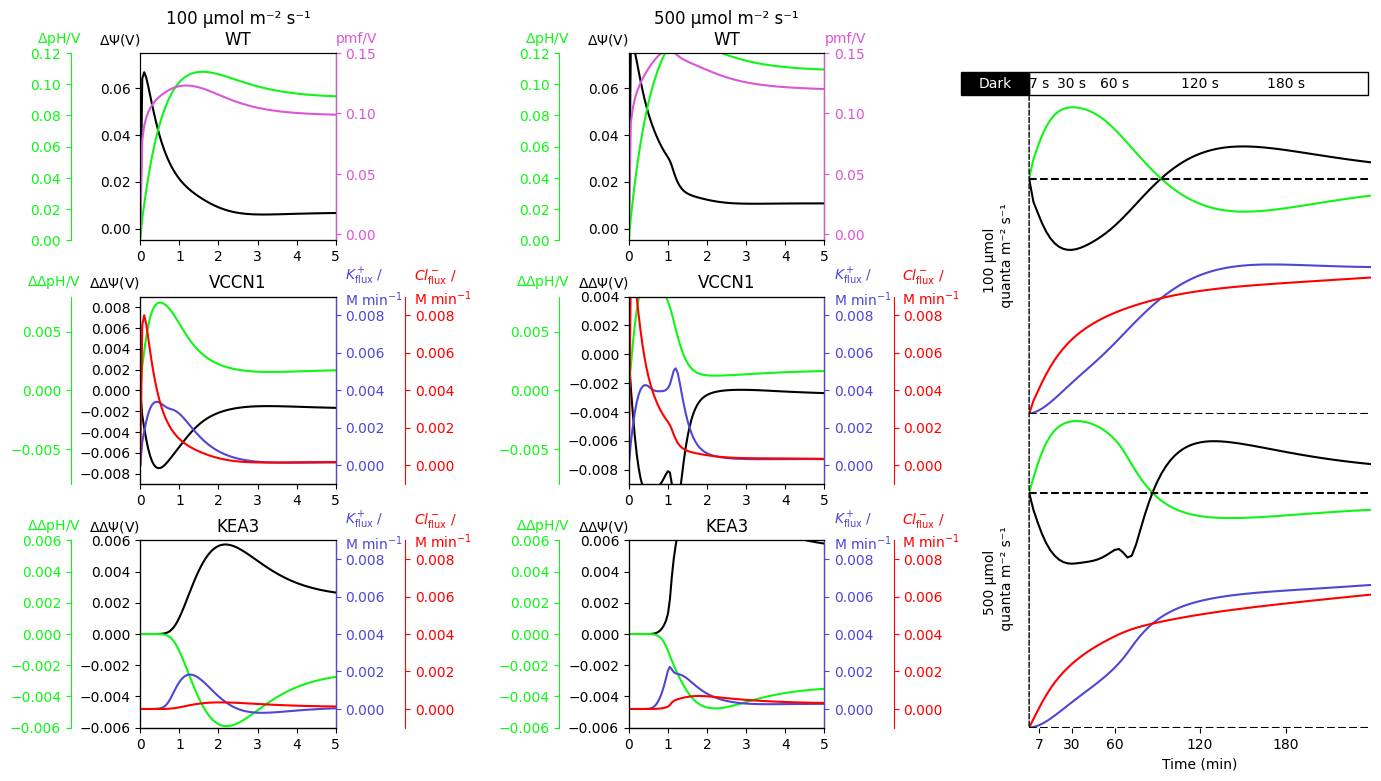

In [174]:
fig4_res = create_fig4_sim(
    model=Li2021(),
    pfd_str=pfd_str,
    Kplus_str=Kplus_str,
    Clminus_str=Clminus_str,
)

create_fig4_plot(
    res=fig4_res,
    deltapsi_str=deltapsi_str,
    dphV_str=dphV_str,
    pmf_str=pmf_str,
    Kplus_str=Kplus_str,
    Clminus_str=Clminus_str,
)

save_fig("4")

# Figure 5

In [175]:
def one(x: float) -> int:
    return 1

def _pfd_osc(time: float, f: float, pfd_add: float) -> float:
    res = 500 + pfd_add * np.sin(2 * np.pi * f * time)
    return res

def osc_sim(
    input: tuple[Model, float]
):
    model = input[0]
    f_val = input[1]
    new_model = copy.deepcopy(model)
    new_model.add_parameter("f", f_val)
    new_model.add_parameter("pfd_add", 0)
    new_model.remove_parameter(pfd_str)
    new_model.add_derived(
        name=pfd_str,
        fn=_pfd_osc,
        args=["time", "f", "pfd_add"]
    )
    prtc = make_protocol([
        (1000, {"pfd_add": 0}),
        (1000, {"pfd_add": 400}),
        (1000, {"pfd_add": 400}),
        (1000, {"pfd_add": 400})
    ])
    s = Simulator(new_model)
    s.simulate_protocol(prtc, time_points_per_step=1000)
    
    return s.get_result().unwrap_or_err().get_combined()

def per_concs_sim(
    input: dict
):
    model: Model = input["model"]
    ratecons_to_change = input["ratecons_to_change"]
    multiplier = input["multiplier"]
    pfd_str = input["pfd_str"]
    pfd_val = input["pfd_val"]

    model.update_parameter(ratecons_to_change, model.get_parameter_values()[ratecons_to_change] * multiplier)
    s = Simulator(model)
    s.simulate_protocol(make_protocol([(50, {pfd_str: pfd_val}), (20 * 60 - 50, {pfd_str: pfd_val}), (5 * 60, {pfd_str: 0})]), time_points_per_step=1000)
    
    return s.get_result().unwrap_or_err().get_combined()

def concs_sim(
    input: dict
):
    model: Model = input["model"]
    pfd_str = input["pfd_str"]
    ratecons_to_change = input["ratecons_to_change"]
    pfd_val = input["pfd_val"]
    new_model = copy.deepcopy(model)
    new_model.update_parameter(pfd_str, pfd_val)
    res = parallelise(
        fn=per_concs_sim,
        inputs=[("0.01", {"model": new_model, "ratecons_to_change": ratecons_to_change, "multiplier": 0.01, "pfd_val": pfd_val, "pfd_str": pfd_str}), ("0.1", {"model": new_model, "ratecons_to_change": ratecons_to_change, "multiplier": 0.1, "pfd_val": pfd_val, "pfd_str": pfd_str}), ("1", {"model": new_model, "ratecons_to_change": ratecons_to_change, "multiplier": 1, "pfd_val": pfd_val, "pfd_str": pfd_str}), ("10", {"model": new_model, "ratecons_to_change": ratecons_to_change, "multiplier": 10, "pfd_val": pfd_val, "pfd_str": pfd_str}), ("100", {"model": new_model, "ratecons_to_change": ratecons_to_change, "multiplier": 100, "pfd_val": pfd_val, "pfd_str": pfd_str})],
        tqdm_desc=f"Running concentration sims for {ratecons_to_change}",
    )
    
    final_res = {}
    for key, df in res:
        final_res[key] = df
    
    return pd.concat(final_res, names=["Concs"], axis=0)

def create_fig5_sim(
    model: Model,
    pfd_str: str,
    qlact_str: str,
    npq_str: str
):
    light_100 = make_protocol([(20 * 60, {pfd_str: 100}), (5 * 60, {pfd_str: 0})])
    light_500 = make_protocol([(20 * 60, {pfd_str: 500}), (5 * 60, {pfd_str: 0})])

    param_dict = {
        "wt": {},
        "c": {"k_CLCE": 0},
        "v": {"k_VCCN1": 0},
        "k": {"k_KEA": 0},
        "cv": {"k_CLCE": 0, "k_VCCN1": 0},
        "ck": {"k_CLCE": 0, "k_KEA": 0},
        "vk": {"k_VCCN1": 0, "k_KEA": 0},
        "vck": {"k_CLCE": 0, "k_VCCN1": 0, "k_KEA": 0},
    }
    
    final_res_sim = {}
    final_res = {}
    
    for gt, params in param_dict.items():
        new_model = copy.deepcopy(model)
        new_model.update_parameters(params)
        
        res_sim = {}
        for pfd, protocol in zip([500, 100], [light_500, light_100]):
            s = Simulator(new_model)
            s.simulate_protocol(protocol, time_points_per_step=100)
            res_sim[pfd] = s.get_result().unwrap_or_err().get_combined()
        
        final_res_sim[gt] = pd.concat(res_sim, names=["PPFD"], axis=0)
    
    model_kea3_noreg = copy.deepcopy(model)
    model_kea3_noreg.update_derived(qlact_str, fn=one, args=["qL"])
    res_sim = {}
    for pfd, protocol in zip([500, 100], [light_500, light_100]):
            s = Simulator(model_kea3_noreg)
            s.simulate_protocol(protocol, time_points_per_step=100)
            res_sim[pfd] = s.get_result().unwrap_or_err().get_combined()
    final_res_sim["k_noreg"] = pd.concat(res_sim, names=["PPFD"], axis=0)
    
    final_res["Genotypes"] = pd.concat(final_res_sim, names=["Genotypes"], axis=0)
    
    model_wt = copy.deepcopy(model)
    model_kea3 = copy.deepcopy(model)
    model_kea3.update_parameters({"k_KEA": 0})
    
    res_2min_scan = {}
    for m, name in [(model_wt, "wt"), (model_kea3, "kea3"), (model_kea3_noreg, "kea3_noreg")]:
        res_sim = {}
        for pfd in [50, 100, 250, 500, 1000]:
            s = Simulator(m)
            s.update_parameter(pfd_str, pfd)
            s.simulate(2*60)
            res_sim[pfd] = s.get_result().unwrap_or_err().get_combined().iloc[-1]
        res_2min_scan[name] = pd.concat(res_sim, names=["PPFD"], axis=1).T
        
    final_res["2min_scan"] = pd.concat(res_2min_scan, names=["Sims"], axis=0)
    
    model_vccn1 = copy.deepcopy(model)
    model_vccn1.update_parameters({"k_VCCN1": 0})
    
    final_osc_res = {}
    for f_val in [5, 75, 100, 120, 200, 300, 600, 900]:
        osc_res = parallelise(
            fn=osc_sim,
            inputs=[("wt", (model_wt, 1/f_val)), ("vccn1", (model_vccn1, 1/f_val)), ("kea3", (model_kea3, 1/f_val)), ("kea3_noreg", (model_kea3_noreg, 1/f_val))],
            tqdm_desc="Running oscillation simulations",
        )
        res = {}
        for key, df in osc_res:
            res[key] = df
        final_osc_res[str(f_val) + "s"] = pd.concat(res, names=["Genotypes"], axis=0)
    
    final_res["Osc Sim"] = pd.concat(final_osc_res, names=["f Vals"], axis=0)
    temp_df = final_res["Osc Sim"].copy()
    
    tmp_dict_1 = {}
    for gt in ["kea3", "vccn1", "kea3_noreg"]:
        tmp_dict_2 = {}
        for f_val in temp_df.index.get_level_values("f Vals").unique():
            period = int(f_val.replace("s", ""))
            res = (temp_df.loc[f_val, gt][npq_str] - temp_df.loc[f_val, "wt"][npq_str]).copy()
            res = res.iloc[-period*3:]
            tmp_dict_2[period] = res.max() - res.min()
            
        tmp_dict_1[gt] = tmp_dict_2
    final_res["Osc Sim_points"] = pd.DataFrame.from_dict(tmp_dict_1, orient="index")
        
    final_final_concs_res = {}
    
    for pfd in [100, 500]:
        concs_res = parallelise(
            fn=concs_sim,
            inputs=[("vccn1", {"model": model_wt, "pfd_str": pfd_str, "ratecons_to_change": "k_VCCN1", "pfd_val": pfd}), ("kea3", {"model": model_wt, "pfd_str": pfd_str, "ratecons_to_change": "k_KEA", "pfd_val": pfd})],
            tqdm_desc="Running concentration simulations",
        )
    
        final_concs_res = {}
        for key, df in concs_res:
            final_concs_res[key] = df
        
        final_final_concs_res[pfd] = pd.concat(final_concs_res, names=["Genotypes"], axis=0)
        
    final_res["Concs"] = pd.concat(final_final_concs_res, names=["PPFD"], axis=0)
        
    
    return final_res

def create_fig5_plot(
    res: pd.DataFrame,
    npq_str: str,
    dphV_str: str,
    deltapsi_str: str,
):
    
    res_sims = res["Genotypes"]
    res_2min_scan = res["2min_scan"]
    res_osc = res["Osc Sim"]
    res_concs = res["Concs"]
    res_osc_points = res["Osc Sim_points"]
    
    fig = plt.figure(figsize=(20, 15))
    outer_grid = gridspec.GridSpec(5, 1, hspace=0.3, height_ratios=[1, 0.1, 1, 0.1, 1.75], figure=fig)
    row_a = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_grid[0], wspace=0.5)
    row_empty = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer_grid[1])
    row_b = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_grid[2], wspace=0.5)
    row_empty_2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_grid[3], wspace=0.5)
    row_c = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer_grid[4], wspace=0.4, hspace=0.5, width_ratios=[1, 2, 1])
    row_c_part1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=row_c[0], wspace=0.1, hspace=0.5)
    row_c_part2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=row_c[1], wspace=0.4, hspace=0.5)
    row_c_part3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=row_c[2], wspace=0.5, hspace=0.5)
    
    axs = {}
    for i, name in enumerate(["k", "k_noreg", "2min_scan"]):
        ax = fig.add_subplot(row_a[0, i])
        for edge in ["top", "right"]:
            ax.spines[edge].set_visible(False)
        axs[f"rowA_{name}"] = ax
        
    for i, name in enumerate(["5s", "120s", "scan"]):
        ax = fig.add_subplot(row_b[0, i])
        for edge in ["top", "right"]:
            ax.spines[edge].set_visible(False)
        axs[f"rowB_{name}"] = ax
        
    for i, name in enumerate(["kea3", "vccn1"]):
        ax = fig.add_subplot(row_c_part1[i, 0])
        for edge in ["top", "right"]:
            ax.spines[edge].set_visible(False)
        axs[f"rowC_{name}_conc_left"] = ax
        ax = fig.add_subplot(row_c_part1[i, 1])
        for edge in ["top", "right", "left"]:
            ax.spines[edge].set_visible(False)
        axs[f"rowC_{name}_conc_right"] = ax
        ax = fig.add_subplot(row_c_part2[0, i])
        for edge in ["top", "right"]:
            ax.spines[edge].set_visible(False)
        axs[f"rowC_{name}_points_initial"] = ax
        ax = fig.add_subplot(row_c_part2[1, i])
        for edge in ["top", "right"]:
            ax.spines[edge].set_visible(False)
        axs[f"rowC_{name}_points_steadystate"] = ax
        
    ax = fig.add_subplot(row_c_part3[0, 0])
    for edge in ["top", "right"]:
        ax.spines[edge].set_visible(False)
    axs["rowC_vccn1_extrema"] = ax
    
    for i, pos in enumerate(["left", "middle"]):
        ax = fig.add_subplot(row_empty_2[0, i])
        for edge in ["top", "right", "left", "bottom"]:
            ax.spines[edge].set_visible(False)
        axs[f"rowempty2_{pos}"] = ax
    
    style_dict = {
        "100": {"color": "black"},
        "500": {"color": "red"},
        "kea3": {"color": "#ed8f50", "markerfacecolor": "#ed8f50", "markeredgecolor": "black"},
        "kea3_noreg": {"color": "#dd1d21", "markerfacecolor": "#dd1d21", "markeredgecolor": "black"},
        "vccn1": {"color": "#436c54", "markerfacecolor": "#436c54", "markeredgecolor": "black"},
        "concs_0.01": {"color": "#804f41"},
        "concs_0.1": {"color": "#e88a2a"},
        "concs_1": {"color": "#c1bb52"},
        "concs_10": {"color": "#426d53"},
        "concs_100": {"color": "#326576"},
    }
    
    # Row A
    for pfd in [100, 500]:
        axs[f"rowA_k"].plot(res_sims.loc["k", pfd][npq_str] - res_sims.loc["wt", pfd][npq_str], **style_dict[str(pfd)])
        axs[f"rowA_k_noreg"].plot(res_sims.loc["k", pfd][npq_str] - res_sims.loc["k_noreg", pfd][npq_str], **style_dict[str(pfd)])
    
    with_kea3_reg =res_2min_scan.loc["kea3"][npq_str] - res_2min_scan.loc["wt"][npq_str]
    without_kea3_reg = res_2min_scan.loc["kea3"][npq_str] - res_2min_scan.loc["kea3_noreg"][npq_str]
    axs["rowA_2min_scan"].plot(with_kea3_reg, marker="o", **style_dict["kea3"])
    axs["rowA_2min_scan"].plot(without_kea3_reg, marker="o", **style_dict["kea3_noreg"])
    axs["rowA_2min_scan"].plot(abs(with_kea3_reg - without_kea3_reg), marker="o", color="black", ls="--")
    
    for name in  ["k", "k_noreg"]:
        if name == "k":
            title = "With KEA3 regulation"
        else:
            title = "Without KEA3 regulation"
        axs[f"rowA_{name}"].set_title(title)
        axs[f"rowA_{name}"].set_xlabel("Time/min")
        axs[f"rowA_{name}"].set_xlim(0, 25*60)
        axs[f"rowA_{name}"].set_xticks(np.linspace(0, 25, 6)*60, labels=np.linspace(0, 25, 6, dtype=int))
        axs[f"rowA_{name}"].set_ylabel(r"$\Delta$ NPQ")
        axs[f"rowA_{name}"].set_ylim(-0.1, 0.7)
        axs[f"rowA_{name}"].set_yticks(np.linspace(0, 0.6, 3))
    
    axs["rowA_2min_scan"].set_xlabel("Light intensity/µmol quanta\nm⁻² s⁻¹")
    axs["rowA_2min_scan"].set_xlim(0, 1000)
    axs["rowA_2min_scan"].set_xticks(np.linspace(0, 1000, 6))
    
    axs["rowA_2min_scan"].set_ylabel(r"$\Delta$NPQ @ 2 min")
    axs["rowA_2min_scan"].set_ylim(0, 0.375)
    axs["rowA_2min_scan"].set_yticks(np.linspace(0, 0.3, 4))
    
    custom_lines = [
        Line2D([0], [0], color=style_dict["kea3"]["color"], marker="o", markeredgecolor=style_dict["kea3"]["markeredgecolor"], label=r"With KEA3 regulation"),
        Line2D([0], [0], color=style_dict["kea3_noreg"]["color"], marker="o", markeredgecolor=style_dict["kea3_noreg"]["markeredgecolor"], label=r"Without KEA3 regulation"),
        Line2D([0], [0], color="black", marker="o", markeredgecolor="black", label="KEA3 inactivation"),
    ]
    
    axs["rowA_2min_scan"].legend(handles=custom_lines, frameon=False)
    
    
    custom_lines = [
        Line2D([0], [0], color="black", lw=2, label=r"Simulated 100 $\mu$mol m$^{-2}$ s$^{-1}$"),
        Line2D([0], [0], color="red", lw=2, label=r"Simulated 500 $\mu$mol m$^{-2}$ s$^{-1}$")
    ]
    
    fig.legend(
        handles=custom_lines,
        ncol=2,
        frameon=False,
        loc="center left",
        bbox_to_anchor=(row_empty[0].get_position(fig).x0, row_empty[0].get_position(fig).y0) 
    )
    
    # Row B
    for f_val in ["5s", "120s"]:
        for gt in ["kea3", "vccn1", "kea3_noreg"]:
            if gt == "kea3":
                res = (res_osc.loc[f_val, gt][npq_str] - res_osc.loc[f_val, "wt"][npq_str]).copy()
                res = res.iloc[-500:]
                max_val = res.max() + 0.01
                min_val = res.min() - 0.01
            axs[f"rowB_{f_val}"].plot([3500, 4000], [max_val, max_val], color="black")
            axs[f"rowB_{f_val}"].plot([3500, 4000], [min_val, min_val], color="black")
            axs[f"rowB_{f_val}"].text(3750, max_val + 0.02, r"$\Delta$ NPQ", color="black", va="bottom", ha="center")
            axs[f"rowB_{f_val}"].plot(res_osc.loc[f_val, gt][npq_str] - res_osc.loc[f_val, "wt"][npq_str], color=style_dict[gt]["color"])
            axs[f"rowB_{f_val}"].set_xlim(0, 4000)
            axs[f"rowB_{f_val}"].set_ylim(-0.4, 0.35)
            axs[f"rowB_{f_val}"].set_ylabel(r"$\Delta$ NPQ")
    
    for gt in res_osc_points.index:
        axs["rowB_scan"].plot(res_osc_points.loc[gt], marker="o", label=gt, color=style_dict[gt]["color"], markeredgecolor="black")
        
    axs[f"rowB_5s"].set_title(r"f = (5 s)$^{-1}$")
    axs[f"rowB_120s"].set_title(r"f = (120 s)$^{-1}$")

    for f_val, side in zip([5, 120], ["left", "middle"]):
        axs[f"rowempty2_{side}"].plot([-100, 0, 0, 1000], [0, 0, 500, 500], color="black")
        x_vals = np.linspace(1000, 4000, 1000)
        axs[f"rowempty2_{side}"].plot(x_vals, 500 + 400 * np.sin(2 * np.pi * x_vals * 1/f_val), color="black")
        axs[f"rowempty2_{side}"].set_ylim(0, 910)
        axs[f"rowempty2_{side}"].set_xlim(-100, 4000)
        axs[f"rowempty2_{side}"].set_xticks([])
        axs[f"rowempty2_{side}"].set_yticks([])
        axs[f"rowempty2_{side}"].text(0, 600, "500")
        axs[f"rowempty2_{side}"].text(1000, 900, "900", ha="right", va="bottom")
        axs[f"rowempty2_{side}"].text(1000, 200, "100", ha="right", va="top")
        
    axs["rowB_scan"].set_ylabel(r"$\Delta$ NPQ")
    axs["rowB_scan"].set_ylim(0, 0.25)
    axs["rowB_scan"].set_yticks(np.linspace(0, 0.2, 3))
    axs["rowB_scan"].set_xlabel("f$^{-1}$ (s)")
    axs["rowB_scan"].set_xlim(0, 1000)
    axs["rowB_scan"].set_xticks(np.linspace(0, 1000, 6))
    
    # Row C
    for gt in ["kea3", "vccn1"]:
        for pfd in [100, 500]:
            this_res = res_concs.loc[pfd, gt].copy()
            for i, conc in enumerate(this_res.index.get_level_values("Concs").unique()):
                
                if pfd == 100:
                    axs[f"rowC_{gt}_conc_left"].plot(this_res.loc[conc][dphV_str] - this_res.loc["1"][dphV_str], color=style_dict[f"concs_{conc}"]["color"])
                    axs[f"rowC_{gt}_conc_right"].plot(this_res.loc[conc][dphV_str] - this_res.loc["1"][dphV_str], color=style_dict[f"concs_{conc}"]["color"])
                
                inital_res = (this_res.loc[conc].loc[50] - this_res.loc[conc].loc[0]) - (this_res.loc["1"].loc[50] - this_res.loc["1"].loc[0]).copy()
                axs[f"rowC_{gt}_points_initial"].scatter(i, inital_res[dphV_str], edgecolor=style_dict[str(pfd)]["color"], facecolor="white")
                axs[f"rowC_{gt}_points_initial"].scatter(i, inital_res[deltapsi_str], marker="^", edgecolor=style_dict[str(pfd)]["color"], facecolor="white")
                
                steady_state_res = this_res.loc[conc].loc[20*60]  - this_res.loc["1"].loc[20*60]
                axs[f"rowC_{gt}_points_steadystate"].scatter(i, steady_state_res[dphV_str], edgecolor=style_dict[str(pfd)]["color"], facecolor="white")
                axs[f"rowC_{gt}_points_steadystate"].scatter(i, steady_state_res[deltapsi_str], marker="^", edgecolor=style_dict[str(pfd)]["color"], facecolor="white")
                
        for plot in ["initial", "steadystate"]:
            axs[f"rowC_{gt}_points_{plot}"].set_ylim(-0.04, 0.04)
            axs[f"rowC_{gt}_points_{plot}"].set_yticks(np.linspace(-0.04, 0.04, 5))
            xlim = axs[f"rowC_{gt}_points_{plot}"].get_xlim()
            axs[f"rowC_{gt}_points_{plot}"].set_xticks(range(5), labels=["0.01", "0.1", "1", "10", "100"])
            axs[f"rowC_{gt}_points_{plot}"].plot([xlim[0], xlim[1]], [0, 0], color="black", ls="--")
            axs[f"rowC_{gt}_points_{plot}"].set_xlim(xlim)
            text = "initial" if plot == "initial" else "steady state"
            axs[f"rowC_{gt}_points_{plot}"].text(0.5, 1, f"{gt.upper()}\n{text}", ha="center", va="top", transform=axs[f"rowC_{gt}_points_{plot}"].transAxes)
            if gt == "kea3":
                axs[f"rowC_{gt}_points_{plot}"].set_ylabel(r"$\Delta$ pH or $\Delta \Psi$ (V)")
            
        center_x = (axs[f"rowC_{gt}_conc_left"].get_position().x0 + axs[f"rowC_{gt}_conc_right"].get_position().x1) / 2
        fig.text(center_x, axs[f"rowC_{gt}_conc_left"].get_position().y1, f"{gt.upper()}\n100 µmol quanta m⁻² s⁻¹", va="top", ha="center")
        
        axs[f"rowC_{gt}_conc_left"].set_xlim(0, 3*60)
        axs[f"rowC_{gt}_conc_right"].set_xlim(19*60, 22*60)
        
    for pfd in [100, 500]:
        for i, conc in enumerate(res_concs.loc[pfd, "vccn1"].index.get_level_values("Concs").unique()):
            thisres = res_concs.loc[pfd, "vccn1", conc].loc[res_concs.loc[pfd, "vccn1", conc].index < 60].copy() - res_concs.loc[pfd, "vccn1", "1"].loc[res_concs.loc[pfd, "vccn1", conc].index < 60].copy()
            peaks = thisres[(thisres[dphV_str] > thisres[dphV_str].shift(1)) & (thisres[dphV_str] > thisres[dphV_str].shift(-1))][dphV_str]
            valleys = thisres[(thisres[dphV_str] < thisres[dphV_str].shift(1)) & (thisres[dphV_str] < thisres[dphV_str].shift(-1))][dphV_str]
            extrema = pd.concat([peaks, valleys]).sort_index()
            if not extrema.empty:
                axs["rowC_vccn1_extrema"].scatter(i, extrema.index[-1], edgecolor=style_dict[str(pfd)]["color"], facecolor="white", marker="^")
        
    for side in ["left", "right"]:
        axs[f"rowC_kea3_conc_{side}"].set_ylim(-0.05, 0.03)
        axs[f"rowC_vccn1_conc_{side}"].set_ylim(-0.03, 0.05)
        
    for gt in ["kea3", "vccn1"]:
        axs[f"rowC_{gt}_conc_left"].set_xticks([i * 60 for i in range(4)], labels=[0, 1, 2, 3])
        axs[f"rowC_{gt}_conc_left"].set_ylabel(r"$\Delta$ pH (V)")
        
        axs[f"rowC_{gt}_conc_right"].set_xticks([i * 60 for i in range(20, 23)], labels=range(20, 23))
        axs[f"rowC_{gt}_conc_right"].set_yticks([])
        
    axs[f"rowC_kea3_conc_left"].set_yticks(np.linspace(-0.04, 0.02, 4))
    axs[f"rowC_vccn1_conc_left"].set_yticks(np.linspace(-0.02, 0.04, 4))
    
    width_conc_left = axs["rowC_kea3_conc_right"].get_position().x1 - axs["rowC_kea3_conc_left"].get_position().x0
    width_part = width_conc_left/5
    gap_fraction = 0.2
    width_streak = width_part * (1 - gap_fraction)
    height_conc_left = axs["rowC_kea3_conc_left"].get_position().y1 - axs["rowC_kea3_conc_left"].get_position().y0
    y_fraction = 0.15
    y_pos = axs["rowC_kea3_conc_left"].get_position().y0 + height_conc_left * y_fraction
    
    prior = axs["rowC_kea3_conc_left"].get_position().x0 + (width_part * gap_fraction)
    for i, key in enumerate(["concs_100", "concs_10", "concs_1", "concs_0.1", "concs_0.01"]):
        num = key.split("_")[1]
        fig.add_artist(
            plt.Line2D(
                xdata=[prior, prior + width_streak],
                ydata=[y_pos, y_pos],
                color=style_dict[key]["color"]
            )
        )
        fig.text(
            x=prior + (width_streak / 2),
            y=y_pos - height_conc_left * 0.02,
            s=num,
            ha="center",
            va="top"
        )
        prior += width_streak + (width_part * gap_fraction)
        
    center_x = (axs["rowC_vccn1_conc_left"].get_position().x0 + axs["rowC_vccn1_conc_right"].get_position().x1) / 2
    fig.text(center_x, axs["rowC_vccn1_conc_left"].get_position().y0 * 0.8, f"Time (min)", va="top", ha="center")
        
    lines = [
        plt.Line2D([0], [0], color="white", markeredgecolor=style_dict["100"]["color"], marker="o", label=r"$\Delta$pH, 100"),
        plt.Line2D([0], [0], color="white", markeredgecolor=style_dict["500"]["color"], marker="o", label=r"$\Delta$pH, 500"),
        plt.Line2D([0], [0], color="white", markeredgecolor=style_dict["100"]["color"], marker="^", label=r"$\Delta \Psi$, 100"),
        plt.Line2D([0], [0], color="white", markeredgecolor=style_dict["500"]["color"], marker="^", label=r"$\Delta \Psi$, 500"),
    ]
    
    axs["rowC_kea3_points_initial"].legend(
        handles=lines,
        frameon=False,
        ncols=2
    )
    
    center_x = (axs["rowC_kea3_points_steadystate"].get_position().x0 + axs["rowC_vccn1_points_steadystate"].get_position().x1) / 2
    fig.text(center_x, axs["rowC_kea3_points_steadystate"].get_position().y0 * 0.80, f"Abundance relative to WT", va="top", ha="center")
    
    axs["rowC_vccn1_extrema"].set_xlabel("Abundance relative to WT")
    axs["rowC_vccn1_extrema"].set_xticks(range(5), labels=["0.01", "0.1", "1", "10", "100"])
    axs["rowC_vccn1_extrema"].set_ylabel("Time to extrema (s)")
    axs["rowC_vccn1_extrema"].set_yticks(np.linspace(0, 30, 7))
    
    lines = [
        plt.Line2D([0], [0], color="white", markeredgecolor=style_dict["100"]["color"], marker="^", label="100"),
        plt.Line2D([0], [0], color="white", markeredgecolor=style_dict["500"]["color"], marker="^", label="500"),
    ]
    
    axs["rowC_vccn1_extrema"].legend(
        handles=lines,
        frameon=False,
        title="µmol quanta m⁻² s⁻¹",
        loc="lower left"
    )
    
    return fig, axs

Running concentration simulations: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


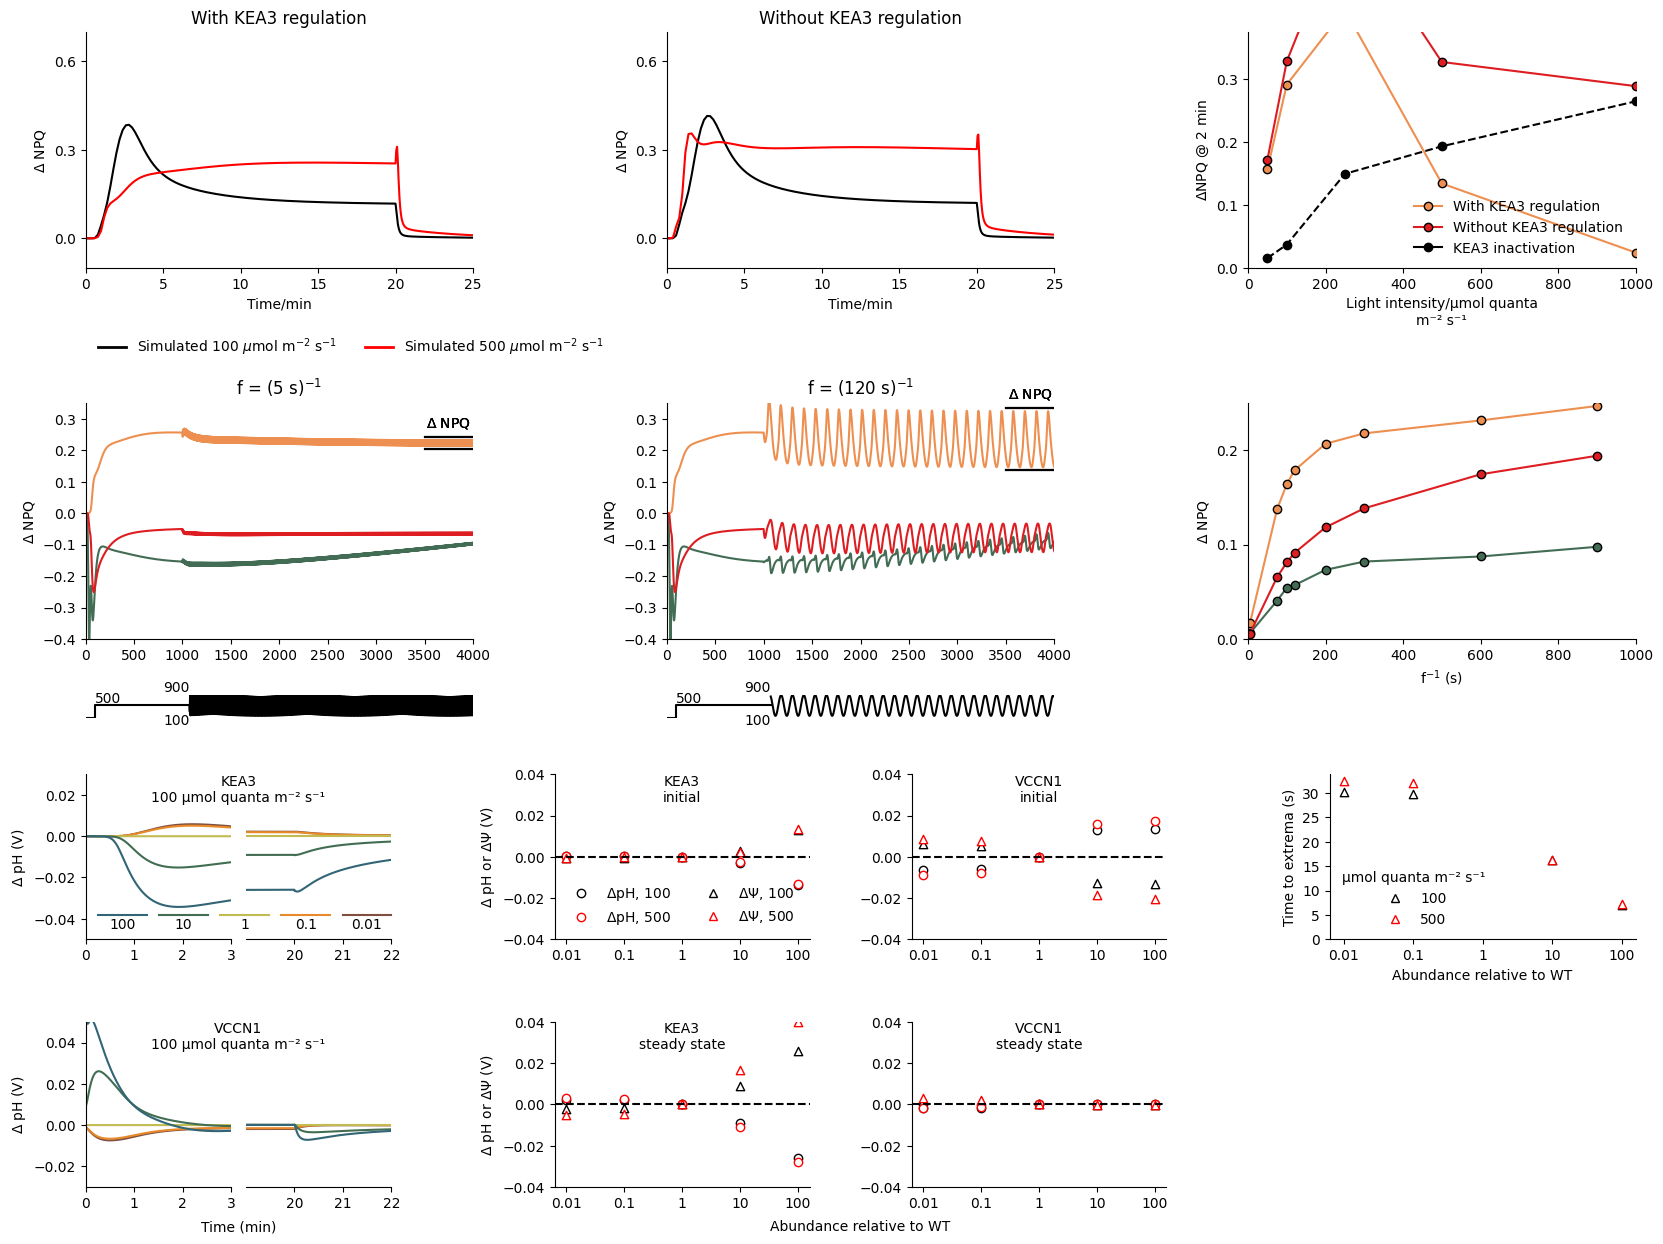

In [176]:
fig5_res = create_fig5_sim(
    model=Li2021(),
    pfd_str=pfd_str,
    qlact_str=qlact_str,
    npq_str=npq_str,
)

create_fig5_plot(
    res=fig5_res,
    npq_str=npq_str,
    dphV_str=dphV_str,
    deltapsi_str=deltapsi_str,
)

save_fig("5")